In [1]:
import pandas as pd
import numpy as np

In [2]:
with open("sent_corpus.csv", "r") as sent_file:
    lines = sent_file.read().split("\n")

In [ ]:
%time rows = [line.split(",") for line in lines if line]
%time rows = [row[:3] + [",".join(row[3:])] for row in rows]
%time sentDf = pd.DataFrame(rows[1:],columns=rows[0])
sentDf[["ItemID","Sentiment"]] = sentDf[["ItemID","Sentiment"]].astype(int)

In [3]:
%%time
sentDf["SentimentText"] = sentDf["SentimentText"].apply(lambda text: text.split())

CPU times: user 3.63 s, sys: 624 ms, total: 4.26 s
Wall time: 4.42 s


In [32]:
import gensim
%time w2vM = gensim.models.Word2Vec(sentDf["SentimentText"])

In [238]:
Ns = int(1e5)

In [358]:
%%time
tvecs = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in sentDf["SentimentText"][:Ns]])
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])

CPU times: user 9.74 s, sys: 958 ms, total: 10.7 s
Wall time: 12.4 s


In [359]:
N = int(1e5)
X = tvecs[:N]
# from sklearn import decomposition
# %time X = sklearn.decomposition.SparsePCA(n_components = 10).fit_transform(X)
y = sentDf["Sentiment"][:N].values
# inverse classifier
# y = 1 - y

In [360]:
ratio = 0.8
tidx = np.random.rand(N) < ratio
pidx = ~tidx

In [361]:
from sklearn import ensemble
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
%time rf.fit(X[tidx],y[tidx])
# gb = sklearn.ensemble.GradientBoostingClassifier()
# %time gb.fit(X[tidx],y[tidx])

CPU times: user 5.88 s, sys: 169 ms, total: 6.05 s
Wall time: 6.82 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [362]:
clf = rf

In [363]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [364]:
from matplotlib import pyplot as plt
% matplotlib inline

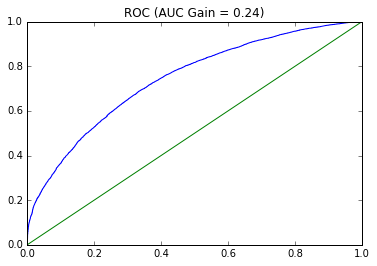

In [365]:
probs = clf.predict_proba(X[pidx])
fpr, tpr, thresholds = roc_curve(y[pidx], probs[:, 1])
roc_auc = auc(fpr, tpr)
roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
plt.plot(fpr, tpr, lw=1,label=roc_str)
plt.plot([0,1],[0,1],label="RAN CLF")
plt.title(roc_str)

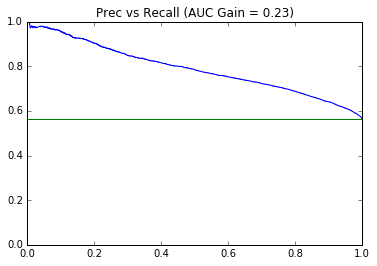

In [366]:
pr, rc, thresholds = precision_recall_curve(y[pidx], probs[:, 1])
roc_auc = auc(rc, pr)
roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
plt.plot(rc,pr, lw=1,label=roc_str)
plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
plt.axis([0,1,0,1])
plt.title(roc_str)

In [367]:
%%time
idx = pidx
yhat = clf.predict(X[idx])
accu = np.mean(yhat == y[idx])
prec = np.mean(y[idx][yhat == 1])
recl = np.mean(yhat[y[idx] == 1])
f1 = 2 * prec * recl / (prec + recl)
print("PREDICT","Accuracy",accuracy,"Precision",prec,"Recall",recl,"F1",f1)

PREDICT Accuracy 0.673612152101 Precision 0.67805020432 Recall 0.821646476258 F1 0.7429736537
CPU times: user 46.5 ms, sys: 10.3 ms, total: 56.8 ms
Wall time: 79.5 ms


In [368]:
%%time
idx = tidx
yhat = clf.predict(X[idx])
accu = np.mean(yhat == y[idx])
prec = np.mean(y[idx][yhat == 1])
recl = np.mean(yhat[y[idx] == 1])
f1 = 2 * prec * recl / (prec + recl)
print("TRAIN","Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

TRAIN Accuracy 0.684591533095 Precision 0.681912795793 Recall 0.82712112152 F1 0.747530549134
CPU times: user 135 ms, sys: 27.2 ms, total: 162 ms
Wall time: 175 ms
